# SetFit - Few-shot Learning with SBERT

Sentence Transformer Fine-tuning is an efficient and prompt-free framework for few-shot fine-tuning of sentence transformers (ST).
1. SetFit works by first fine-tuning a pretrained ST on a small number of text pairs, in a contrastive Siamese manner.
2. The resulting model is then used to generate rich text embeddings, whicha re used to train a classification model.

This simple framework requires no prompts or verbalizers, and achieves high accuracy with orders of magnitude less parameters than existing techniques.

References:
* https://arxiv.org/pdf/2209.11055.pdf
* https://github.com/huggingface/setfit
* https://www.youtube.com/watch?v=5BGaJWf50xg
* https://www.youtube.com/watch?v=6gC_dR71hRA

# SetFit example with 2 classes


The data set we are gonna use is SST2, available in Huggingface: The Stanford Sentiment Treebank is a corpus with fully labeled parse trees that allows for a complete analysis of the compositional effects of sentiment in language. The corpus consists of 11,855 single sentences extracted from movie reviews. It was parsed with the Stanford parser and includes a total 215,154 unique phrases from those parse trees, each annotated by 3 human judges.

In [36]:
!pip install setfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss

from setfit import SetFitModel, SetFitTrainer

# Load a dataset from the Hugging Face hub

dataset = load_dataset("sst2")
dataset

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset sst2 downloaded and prepared to /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [3]:
# Simulate the few-shot regime by sampling 8 examples per class

num_samples = 8
num_classes = 2

train_dataset = dataset['train'].shuffle(seed=42).select(range(num_samples * num_classes))
train_dataset

Dataset({
    features: ['idx', 'sentence', 'label'],
    num_rows: 16
})

In [4]:
# For evaluation, we'll use the validation split, since the test split of sst2 is unlabeled
eval_dataset = dataset['validation']

## Fine-tuning the SetFit model

In [5]:
# Load a SetFit model from Huggingface

model_id = "sentence-transformers/paraphrase-mpnet-base-v2"
model = SetFitModel.from_pretrained(model_id)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [6]:
# Create a trainer

trainer = SetFitTrainer(
    model= model,
    train_dataset=train_dataset,
    eval_dataset= eval_dataset,
    loss_class= CosineSimilarityLoss,
    metric= "accuracy",
    batch_size= 16,
    num_iterations= 20, # The number of text pairs to generate contrastive- Siamese manner learning
    num_epochs= 1, # The number of epochs to use for constractive learning
    column_mapping= {"sentence": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

In [7]:
# Train the model

trainer.train()

Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 640
  Num epochs = 1
  Total optimization steps = 40
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

In [8]:
# The final step is to compute the model's performance using the evaluate() method:

metrics = trainer.evaluate()
metrics

Applying column mapping to evaluation dataset
***** Running evaluation *****


{'accuracy': 0.6720183486238532}

In [9]:
# Push model to the Hub (Create an account, get credentials, and then do it)
# trainer.push_to_hub("my-first-model")

# Download from Hub and run inference
# model = SetFitModel.from_pretrained("sai/my-first-model")

In [10]:
# Run inference
preds = model(['I loved the spiderman movie!', "pineapple on pizza is the worst 🤮"])
preds

tensor([1, 0])

## Training SetFit on Multilabel datasets

To train SetFit models on multilabel datasets, specificy the multi_target_strategy argument when loading the pretrained model:

In [11]:
from setfit import SetFitModel

model = SetFitModel.from_pretrained(model_id, multi_target_strategy="one-vs-rest")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


This will initiate a multilabel classification head from sklearn - the following options are available for multi_target_strategy:
1. one-vs-rest: use a OneVsRestClassifier head
2. multi-output: use a MultiOutputClassifier head
3. classifier-chain: use a ClassifierChain head

In [12]:
model_id = "sentence-transformers/paraphrase-mpnet-base-v2"
dataset = load_dataset("ethos", "multilabel")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/433 [00:00<?, ? examples/s]

Dataset ethos downloaded and prepared to /root/.cache/huggingface/datasets/ethos/multilabel/1.0.0/898d3d005459ee3ff80dbeec2f169c6b7ea13de31a08458193e27dec3dd9ae38. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
import numpy as np

features = dataset['train'].column_names
features.remove('text')
features

['violence',
 'directed_vs_generalized',
 'gender',
 'race',
 'national_origin',
 'disability',
 'religion',
 'sexual_orientation']

In [14]:
num_samples = 8
samples = np.concatenate(
    [np.random.choice(np.where(dataset['train'][f])[0],  num_samples) for f in features]
)

In [15]:
# We encode the emotions in a single 'label' feature.

def encode_labels(record):
    return {"labels": [record[feature] for feature in features]}

dataset = dataset.map(encode_labels)

Map:   0%|          | 0/433 [00:00<?, ? examples/s]

Next, we use the samples we selected as our training set, and the others as our test set (since the ethos dataset does not have a test split on the hub).

Here we have 64 total examples to train with since the ethos dataset has 8 classes.

In [16]:
train_dataset = dataset['train'].select(samples)
eval_dataset = dataset['train'].select(
    np.setdiff1d(np.arange(len(dataset['train'])), samples)
)

## Fine-tuning the multi-label SetFit model

In [17]:
from setfit import SetFitModel

model2 = SetFitModel.from_pretrained(model_id, multi_target_strategy='one-vs-rest')

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [18]:
trainer2 = SetFitTrainer(
    model= model2,
    train_dataset= train_dataset,
    eval_dataset= eval_dataset,
    loss_class= CosineSimilarityLoss,
    batch_size= 16,
    num_epochs= 1,
    num_iterations= 20,
    column_mapping= {"text": "text", "labels": "label"}
)

In [19]:
trainer2.train()

Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 3780
  Num epochs = 1
  Total optimization steps = 237
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

In [20]:
metrics2 = trainer2.evaluate()
metrics2

# Increasing the number of epochs, iterations, training samples, and batch_size can increase the performance.

Applying column mapping to evaluation dataset
***** Running evaluation *****


{'accuracy': 0.3850267379679144}

In [21]:
preds2 = model2(
    [
        "Jewish People often don't eat pork.",
        "Is this lipstick suitable for people with dark skin?",
        "Is policy based on scientific facts or emotional polarisation?"
    ]    
)

preds2

tensor([[0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0]])

In [22]:
# Show predicted labels, requires you to have stored the 'features' somewhere

[[f for f, p in zip(features, ps) if p] for ps in preds2]

[['religion'], ['directed_vs_generalized'], ['disability']]

# Hyperparameter Optimization for SetFit

SetFitTrainer provides a hyperparameter_search() method that you can use to find good hyperparameters of your system for your data. To use this feature, first install the optuna backend for HyperParameter Optimization - HPO:

In [37]:
!pip install setfit[optuna]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use this method, you need to define two functions:
1. model_init(): A function that instantiaties the model to be used. If provided, each call to train() will start from a new instance of the model as given by this function.
2. hp_space(): A function that defines the hyperparameter search space.

## Start Demo/Theory

Here is an example of a model_init() function that we'll use to scan over the hyperparameters associated with the classification head in SetFitModel:

In [38]:
from setfit import SetFitModel

def model_init(params):
    params = params or {}
    max_iter = params.get("max_iter", 100)
    solver = params.get("solver", "liblinear")
    params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }
    return SetFitModel.from_pretrained("sentence-transformers/paraphrase-albert-small-v2", **params)

Similarly, to scan over hyperparameters associated with the SetFit training process, we can define a hpo_space() function as follows:

In [39]:
# class optuna.trail.Trail(study, trail_id)

# A trail is a process of evaluating an objective function.
# This object is passed to an objective function and provides interfaces to get parameter suggestion,
# manage the trail's state, and set/get user-defined attributes of the trail.

# suggest_int(name, low, high[, step, log]) ....... Suggest a value for the integer parameter.
# suggest_categorical(name, choices)        ....... Suggest a value for the categorical parameter.

In [40]:
 def hp_space(trail):
    return {
        "learning_rate": trail.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "num_epochs": trail.suggest_int("num_epochs", 1, 5),
        "batch_size": trail.suggest_categorical("batch_size", [4, 8, 16, 32, 64]),
        "seed": trail.suggest_int("seed", 1, 40),
        "num_iteratioins": trail.suggest_categorical("num_iterations", [5, 10, 20]),
        "max_iter": trail.suggest_int("max_iter", 50, 300),
        "solver": trail.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear"])
    }


# solver applies iterative methods for solving nonlinear optimization problems.
# We need Hessian matrix a square matrix of second-order partial derivaties of scalar field.
# it describes the local curvature of a function of many variables.

# Newton conjugate gradient algorithm: Of all the methods for minimizing a functional,
# the conjugate-gradient method gives the maximal minimization after n steps.

# Limited-memory BFGS (L-BFGS or LM-BFGS) is an optimization algorithm in the family of
# quasi-Newton methods that approximates the Broyden-Fletcher-Goldfarb-Shanno algorithm (BFGS)
# using a limited amount of computer memory

In [41]:
# Exercise: Compare the convergence of gradient descent with optimal step size and conjugate vector for minimizing a function

# The next step is to instantitate a SetFitTrainer and call hyperparameter_search():

In [42]:
from datasets import Dataset
from setfit import SetFitTrainer

dataset = Dataset.from_dict(
    {"text_new": ["a", "b", "c"], "label_new": [0, 1, 2], "extra_column": ["d", "e", "f"]}
)

dataset

Dataset({
    features: ['text_new', 'label_new', 'extra_column'],
    num_rows: 3
})

In [44]:
# Trainer

trainer = SetFitTrainer(
    train_dataset = dataset,
    eval_dataset = dataset,
    model_init = model_init,
    column_mapping= {"text_new": "text", "label_new": "label"},
)

best_run = trainer.hyperparameter_search(direction='maximize', hp_space= hp_space, n_trials=20)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
[I 2023-04-25 18:19:05,205] A new study created in memory with name: no-name-89486c67-6a16-4c05-89b9-56baf5f1b179
Trial: {'learning_rate': 1.6515252645841325e-06, 'num_epochs': 3, 'batch_size': 64, 'seed': 34, 'num_iteratioins': 20, 'max_iter': 55, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 3
  Total optimization steps = 6
  Total train batch size = 64


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:06,746] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 1.6515252645841325e-06, 'num_epochs': 3, 'batch_size': 64, 'seed': 34, 'num_iterations': 20, 'max_iter': 55, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 6.850194044331555e-05, 'num_epochs': 4, 'batch_size': 64, 'seed': 35, 'num_iteratioins': 5, 'max_iter': 207, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 4
  Total optimization steps = 8
  Total train batch size = 64


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:08,204] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 6.850194044331555e-05, 'num_epochs': 4, 'batch_size': 64, 'seed': 35, 'num_iterations': 5, 'max_iter': 207, 'solver': 'lbfgs'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 3.446679548704577e-06, 'num_epochs': 4, 'batch_size': 32, 'seed': 5, 'num_iteratioins': 5, 'max_iter': 284, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 4
  Total optimization steps = 16
  Total train batch size = 32


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:09,922] Trial 2 finished with value: 1.0 and parameters: {'learning_rate': 3.446679548704577e-06, 'num_epochs': 4, 'batch_size': 32, 'seed': 5, 'num_iterations': 5, 'max_iter': 284, 'solver': 'lbfgs'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 1.4487148984522522e-05, 'num_epochs': 1, 'batch_size': 16, 'seed': 28, 'num_iteratioins': 20, 'max_iter': 208, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 1
  Total optimization steps = 8
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:11,385] Trial 3 finished with value: 1.0 and parameters: {'learning_rate': 1.4487148984522522e-05, 'num_epochs': 1, 'batch_size': 16, 'seed': 28, 'num_iterations': 20, 'max_iter': 208, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 1.2210646128272075e-05, 'num_epochs': 1, 'batch_size': 4, 'seed': 17, 'num_iteratioins': 20, 'max_iter': 152, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 1
  Total optimization steps = 30
  Total train batch size = 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:13,486] Trial 4 finished with value: 1.0 and parameters: {'learning_rate': 1.2210646128272075e-05, 'num_epochs': 1, 'batch_size': 4, 'seed': 17, 'num_iterations': 20, 'max_iter': 152, 'solver': 'newton-cg'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 2.2084688258748554e-05, 'num_epochs': 1, 'batch_size': 4, 'seed': 8, 'num_iteratioins': 5, 'max_iter': 253, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 1
  Total optimization steps = 30
  Total train batch size = 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:15,678] Trial 5 finished with value: 1.0 and parameters: {'learning_rate': 2.2084688258748554e-05, 'num_epochs': 1, 'batch_size': 4, 'seed': 8, 'num_iterations': 5, 'max_iter': 253, 'solver': 'lbfgs'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 1.1446763793798284e-06, 'num_epochs': 1, 'batch_size': 16, 'seed': 8, 'num_iteratioins': 10, 'max_iter': 182, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 1
  Total optimization steps = 8
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:17,149] Trial 6 finished with value: 1.0 and parameters: {'learning_rate': 1.1446763793798284e-06, 'num_epochs': 1, 'batch_size': 16, 'seed': 8, 'num_iterations': 10, 'max_iter': 182, 'solver': 'newton-cg'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 1.4048177222124362e-05, 'num_epochs': 4, 'batch_size': 64, 'seed': 16, 'num_iteratioins': 20, 'max_iter': 117, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 4
  Total optimization steps = 8
  Total train batch size = 64


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:18,834] Trial 7 finished with value: 1.0 and parameters: {'learning_rate': 1.4048177222124362e-05, 'num_epochs': 4, 'batch_size': 64, 'seed': 16, 'num_iterations': 20, 'max_iter': 117, 'solver': 'lbfgs'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 1.8793447494152368e-05, 'num_epochs': 2, 'batch_size': 64, 'seed': 29, 'num_iteratioins': 10, 'max_iter': 149, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 2
  Total optimization steps = 4
  Total train batch size = 64


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:20,224] Trial 8 finished with value: 1.0 and parameters: {'learning_rate': 1.8793447494152368e-05, 'num_epochs': 2, 'batch_size': 64, 'seed': 29, 'num_iterations': 10, 'max_iter': 149, 'solver': 'newton-cg'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 6.041663186723535e-06, 'num_epochs': 5, 'batch_size': 64, 'seed': 10, 'num_iteratioins': 10, 'max_iter': 104, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 5
  Total optimization steps = 10
  Total train batch size = 64


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:21,845] Trial 9 finished with value: 1.0 and parameters: {'learning_rate': 6.041663186723535e-06, 'num_epochs': 5, 'batch_size': 64, 'seed': 10, 'num_iterations': 10, 'max_iter': 104, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 1.3520834864035855e-06, 'num_epochs': 3, 'batch_size': 8, 'seed': 40, 'num_iteratioins': 20, 'max_iter': 62, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 3
  Total optimization steps = 45
  Total train batch size = 8


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:25,075] Trial 10 finished with value: 1.0 and parameters: {'learning_rate': 1.3520834864035855e-06, 'num_epochs': 3, 'batch_size': 8, 'seed': 40, 'num_iterations': 20, 'max_iter': 62, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 9.42001245988181e-05, 'num_epochs': 3, 'batch_size': 64, 'seed': 40, 'num_iteratioins': 5, 'max_iter': 227, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 3
  Total optimization steps = 6
  Total train batch size = 64


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:26,441] Trial 11 finished with value: 1.0 and parameters: {'learning_rate': 9.42001245988181e-05, 'num_epochs': 3, 'batch_size': 64, 'seed': 40, 'num_iterations': 5, 'max_iter': 227, 'solver': 'lbfgs'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 8.930743630676233e-05, 'num_epochs': 4, 'batch_size': 64, 'seed': 31, 'num_iteratioins': 5, 'max_iter': 51, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 4
  Total optimization steps = 8
  Total train batch size = 64


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:27,908] Trial 12 finished with value: 1.0 and parameters: {'learning_rate': 8.930743630676233e-05, 'num_epochs': 4, 'batch_size': 64, 'seed': 31, 'num_iterations': 5, 'max_iter': 51, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 4.576055193391944e-05, 'num_epochs': 5, 'batch_size': 8, 'seed': 33, 'num_iteratioins': 5, 'max_iter': 204, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 5
  Total optimization steps = 75
  Total train batch size = 8


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:33,041] Trial 13 finished with value: 1.0 and parameters: {'learning_rate': 4.576055193391944e-05, 'num_epochs': 5, 'batch_size': 8, 'seed': 33, 'num_iterations': 5, 'max_iter': 204, 'solver': 'lbfgs'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 4.991873647023017e-06, 'num_epochs': 2, 'batch_size': 32, 'seed': 25, 'num_iteratioins': 20, 'max_iter': 99, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 2
  Total optimization steps = 8
  Total train batch size = 32


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:34,740] Trial 14 finished with value: 1.0 and parameters: {'learning_rate': 4.991873647023017e-06, 'num_epochs': 2, 'batch_size': 32, 'seed': 25, 'num_iterations': 20, 'max_iter': 99, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 2.33256352014751e-06, 'num_epochs': 3, 'batch_size': 64, 'seed': 36, 'num_iteratioins': 20, 'max_iter': 246, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 3
  Total optimization steps = 6
  Total train batch size = 64


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:36,289] Trial 15 finished with value: 1.0 and parameters: {'learning_rate': 2.33256352014751e-06, 'num_epochs': 3, 'batch_size': 64, 'seed': 36, 'num_iterations': 20, 'max_iter': 246, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 7.702121199721857e-06, 'num_epochs': 4, 'batch_size': 64, 'seed': 23, 'num_iteratioins': 5, 'max_iter': 300, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 4
  Total optimization steps = 8
  Total train batch size = 64


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:37,764] Trial 16 finished with value: 1.0 and parameters: {'learning_rate': 7.702121199721857e-06, 'num_epochs': 4, 'batch_size': 64, 'seed': 23, 'num_iterations': 5, 'max_iter': 300, 'solver': 'lbfgs'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 2.914440657564844e-05, 'num_epochs': 2, 'batch_size': 64, 'seed': 36, 'num_iteratioins': 20, 'max_iter': 164, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 2
  Total optimization steps = 4
  Total train batch size = 64


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:38,942] Trial 17 finished with value: 1.0 and parameters: {'learning_rate': 2.914440657564844e-05, 'num_epochs': 2, 'batch_size': 64, 'seed': 36, 'num_iterations': 20, 'max_iter': 164, 'solver': 'lbfgs'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 7.7640186531083e-06, 'num_epochs': 3, 'batch_size': 4, 'seed': 19, 'num_iteratioins': 5, 'max_iter': 187, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 3
  Total optimization steps = 90
  Total train batch size = 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:43,584] Trial 18 finished with value: 1.0 and parameters: {'learning_rate': 7.7640186531083e-06, 'num_epochs': 3, 'batch_size': 4, 'seed': 19, 'num_iterations': 5, 'max_iter': 187, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.
Trial: {'learning_rate': 2.298410916503736e-06, 'num_epochs': 5, 'batch_size': 8, 'seed': 35, 'num_iteratioins': 10, 'max_iter': 126, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 5
  Total optimization steps = 75
  Total train batch size = 8


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:19:48,431] Trial 19 finished with value: 1.0 and parameters: {'learning_rate': 2.298410916503736e-06, 'num_epochs': 5, 'batch_size': 8, 'seed': 35, 'num_iterations': 10, 'max_iter': 126, 'solver': 'newton-cg'}. Best is trial 0 with value: 1.0.


Finally, you can apply the hyper-parameters you found to the trainer, and lock in the optimal model, before training for a final time.

In [45]:
# Apply optimal parameters to your model

trainer.apply_hyperparameters(best_run.hyperparameters, final_model=True)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [46]:
# train the trainer

trainer.train()

Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 3
  Total optimization steps = 6
  Total train batch size = 64


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

## Example: Coding SetFit Hyperparameter Optimization

In [47]:
import numpy as np
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer

In [49]:
# Everything dataset

def encode_labels(record):
    return {"labels": [record[feature] for feature in features]}

num_samples = 8
dataset = load_dataset("ethos", "multilabel")

features = dataset['train'].column_names
features.remove("text")

samples = np.concatenate([np.random.choice(np.where(dataset['train'][f])[0], num_samples) for f in features])
dataset = dataset.map(encode_labels)

train_dataset = dataset['train'].select(samples)
eval_dataset = dataset['train'].select(np.setdiff1d(np.arange(len(dataset["train"])), samples))

# numpy.setdiff1d(ar1, ar2, assume_unique=False) .... Find the set difference of two arrays.
# Return the unique vvalues in ar1 that are not in ar2.

  0%|          | 0/1 [00:00<?, ?it/s]

In [50]:
train_dataset

Dataset({
    features: ['text', 'violence', 'directed_vs_generalized', 'gender', 'race', 'national_origin', 'disability', 'religion', 'sexual_orientation', 'labels'],
    num_rows: 64
})

In [51]:
eval_dataset

Dataset({
    features: ['text', 'violence', 'directed_vs_generalized', 'gender', 'race', 'national_origin', 'disability', 'religion', 'sexual_orientation', 'labels'],
    num_rows: 373
})

For a hyperparameter search we need several changes to the normal training setup:

Instead of a model, we pass a model_init function, which optionally can use the dictionary of hyper-parameters.

We set up a function that defines which parameters we are intested in optimizing.

In [52]:
model_id = "sentence-transformers/paraphrase-mpnet-base-v2"

def make_model(params=None):
    multi_target_strategy = params["multi_target_strategy"] if params else "one-vs-rest"
    return SetFitModel.from_pretrained(
        model_id, multi_target_strategy=multi_target_strategy
    )

In [54]:
trainer = SetFitTrainer(
    model_init=make_model,
    train_dataset= train_dataset,
    eval_dataset = eval_dataset,
    loss_class=CosineSimilarityLoss,
    num_epochs=1,
    num_iterations=5,
    column_mapping={"text": "text", "labels": "label"}
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


For this particular trail, we try to find the optimal learning_rate, multi_target_strategy, and batch_size for training with only 5 iterations on 8 samples/class.

In [56]:
def hyperparameter_search_function(trail):
    return {
        "learning_rate": trail.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
        "batch_size": trail.suggest_categorical("batch_size", [4, 8, 16, 32]),
        "multi_target_strategy": trail.suggest_categorical("multi_target_strategy", ["one-vs-rest", "multi-output", "classifier-chain"])
    }

In [59]:
best = trainer.hyperparameter_search(hyperparameter_search_function, n_trials=7)
best

[I 2023-04-25 18:45:10,251] A new study created in memory with name: no-name-d04638c5-cedc-4985-88c5-9a9d034d3914
Trial: {'learning_rate': 4.262110036171499e-05, 'batch_size': 32, 'multi_target_strategy': 'classifier-chain'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 930
  Num epochs = 1
  Total optimization steps = 30
  Total train batch size = 32


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:45:38,758] Trial 0 finished with value: 0.38605898123324395 and parameters: {'learning_rate': 4.262110036171499e-05, 'batch_size': 32, 'multi_target_strategy': 'classifier-chain'}. Best is trial 0 with value: 0.38605898123324395.
Trial: {'learning_rate': 0.00010706017397076482, 'batch_size': 4, 'multi_target_strategy': 'classifier-chain'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 930
  Num epochs = 1
  Total optimization steps = 233
  Total train batch size = 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/233 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:46:17,452] Trial 1 finished with value: 0.3002680965147453 and parameters: {'learning_rate': 0.00010706017397076482, 'batch_size': 4, 'multi_target_strategy': 'classifier-chain'}. Best is trial 0 with value: 0.38605898123324395.
Trial: {'learning_rate': 8.759870505833543e-05, 'batch_size': 4, 'multi_target_strategy': 'classifier-chain'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 930
  Num epochs = 1
  Total optimization steps = 233
  Total train batch size = 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/233 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:46:58,663] Trial 2 finished with value: 0.30831099195710454 and parameters: {'learning_rate': 8.759870505833543e-05, 'batch_size': 4, 'multi_target_strategy': 'classifier-chain'}. Best is trial 0 with value: 0.38605898123324395.
Trial: {'learning_rate': 0.00044465653459279286, 'batch_size': 8, 'multi_target_strategy': 'one-vs-rest'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 930
  Num epochs = 1
  Total optimization steps = 117
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/117 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:47:29,048] Trial 3 finished with value: 0.010723860589812333 and parameters: {'learning_rate': 0.00044465653459279286, 'batch_size': 8, 'multi_target_strategy': 'one-vs-rest'}. Best is trial 0 with value: 0.38605898123324395.
Trial: {'learning_rate': 0.00048692891699112363, 'batch_size': 4, 'multi_target_strategy': 'classifier-chain'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 930
  Num epochs = 1
  Total optimization steps = 233
  Total train batch size = 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/233 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:48:05,430] Trial 4 finished with value: 0.010723860589812333 and parameters: {'learning_rate': 0.00048692891699112363, 'batch_size': 4, 'multi_target_strategy': 'classifier-chain'}. Best is trial 0 with value: 0.38605898123324395.
Trial: {'learning_rate': 0.00038730482796621235, 'batch_size': 32, 'multi_target_strategy': 'classifier-chain'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 930
  Num epochs = 1
  Total optimization steps = 30
  Total train batch size = 32


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:48:34,570] Trial 5 finished with value: 0.20107238605898123 and parameters: {'learning_rate': 0.00038730482796621235, 'batch_size': 32, 'multi_target_strategy': 'classifier-chain'}. Best is trial 0 with value: 0.38605898123324395.
Trial: {'learning_rate': 1.891386021713523e-05, 'batch_size': 8, 'multi_target_strategy': 'one-vs-rest'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 930
  Num epochs = 1
  Total optimization steps = 117
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/117 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-04-25 18:49:01,362] Trial 6 finished with value: 0.3806970509383378 and parameters: {'learning_rate': 1.891386021713523e-05, 'batch_size': 8, 'multi_target_strategy': 'one-vs-rest'}. Best is trial 0 with value: 0.38605898123324395.


BestRun(run_id='0', objective=0.38605898123324395, hyperparameters={'learning_rate': 4.262110036171499e-05, 'batch_size': 32, 'multi_target_strategy': 'classifier-chain'}, backend=<optuna.study.study.Study object at 0x7f5f397b3dc0>)

<ipython-input-60-33904a208367>:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(best.backend)


<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

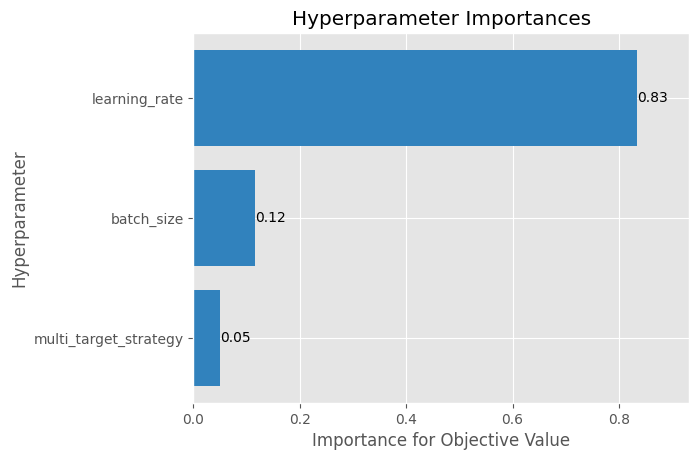

In [60]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(best.backend)

The final step is to train using the optimal parameters and check the model's performance again using the evaluate() method.

In [61]:
trainer.apply_hyperparameters(best.hyperparameters, final_model=True) # replace model_init with a fixed model
trainer.train()

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 930
  Num epochs = 1
  Total optimization steps = 30
  Total train batch size = 32


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

In [62]:
metrics = trainer.evaluate()
best.objective, metrics

Applying column mapping to evaluation dataset
***** Running evaluation *****


(0.38605898123324395, {'accuracy': 0.353887399463807})